# Strategy Analysis with **Pandas TA** and AI/ML
* This is a **Work in Progress** and subject to change!
* Contributions are welcome and accepted!
* Examples below are for **educational purposes only**.

### Required Packages
##### Uncomment the packages you need to install or are missing

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install mplfinance
#!pip install pandas-datareader
#!pip install requests_cache
#!pip install alphaVantage-api

In [2]:
%pylab inline
import datetime as dt
import random as rnd
from sys import float_info as sflt

import numpy as np
import pandas as pd
pd.set_option('max_rows', 100)
pd.set_option('max_columns', 20)

import mplfinance as mpf

from alphaVantageAPI.alphavantage import AlphaVantage
import pandas_ta as ta

from watchlist import colors, Watchlist

print(f"Numpy v{np.__version__}")
print(f"Pandas v{pd.__version__}")
print(f"mplfinance v{mpf.__version__}")
print(f"Pandas TA v{ta.version}")
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib
Numpy v1.19.2
Pandas v1.1.0
mplfinance v0.12.7a0
Pandas TA v0.2.19b0


## MISC Functions

In [3]:
def recent_bars(df, tf: str = "1y"):
    # All Data: 0, Last Four Years: 0.25, Last Two Years: 0.5, This Year: 1, Last Half Year: 2, Last Quarter: 4
    yearly_divisor = {"all": 0, "10y": 0.1, "5y": 0.2, "4y": 0.25, "3y": 1./3, "2y": 0.5, "1y": 1, "6mo": 2, "3mo": 4}
    yd = yearly_divisor[tf] if tf in yearly_divisor.keys() else 0
    return int(ta.RATE["TRADING_DAYS_PER_YEAR"] / yd) if yd > 0 else df.shape[0]

## Collect some Data

In [5]:
tf = "D"
tickers = ["SPY", "QQQ", "AAPL", "TSLA"]
watch = Watchlist(tickers, tf=tf, timed=True)
watch.strategy = ta.CommonStrategy
watch.load(tickers, analyze=True, verbose=False)

[!] Loading All: SPY, QQQ, AAPL, TSLA
[i] Loaded['D']: SPY_D.csv
[i] Runtime: 2625.9568 ms (2.6260 s)
[+] Downloading['D']: QQQ
[i] Runtime: 916.8165 ms (0.9168 s)
[i] Loaded['D']: AAPL_D.csv
[i] Runtime: 1258.2966 ms (1.2583 s)
[+] Downloading['D']: TSLA
[i] Runtime: 1639.8345 ms (1.6398 s)


# Select an Asset

In [14]:
ticker = tickers[0]
# watch.data[ticker].ta.constants(True, [0, 0, 0])
print(f"{ticker} {watch.data[ticker].shape}\nColumns: {', '.join(list(watch.data[ticker].columns))}")

SPY (5260, 10)
Columns: open, high, low, close, volume, SMA_10, SMA_20, SMA_50, SMA_200, VOL_SMA_20


### Trim it

In [15]:
duration = "1y"
recent = recent_bars(watch.data[ticker], duration)
asset = watch.data[ticker].copy().tail(recent)
print(f"{ticker} {asset.shape}\nColumns: {', '.join(list(asset.columns))}")

SPY (252, 10)
Columns: open, high, low, close, volume, SMA_10, SMA_20, SMA_50, SMA_200, VOL_SMA_20


# Create a Trend

In [16]:
# Example Long Trends
# long = ta.sma(asset.close, 10) < ta.sma(asset.close, 20) # SMA(10) > SMA(20)
# long = ta.ema(asset.close, 8) > ta.ema(asset.close, 21) # EMA(8) > EMA(21)
long = ta.increasing(ta.ema(asset.close, 50))
# long = ta.macd(asset.close).iloc[:,1] > 0 # MACD Histogram is positive

asset.ta.ema(length=8, append=True)
asset.ta.ema(length=21, append=True)
asset.ta.ema(length=50, append=True)

date
2019-09-27           NaN
2019-09-30           NaN
2019-10-01           NaN
2019-10-02           NaN
2019-10-03           NaN
                 ...    
2020-09-21    332.547899
2020-09-22    332.459746
2020-09-23    332.074658
2020-09-24    331.738397
2020-09-25    331.620420
Name: EMA_50, Length: 252, dtype: float64

## Calculate Trend Returns from the long trend

In [17]:
trendy = asset.ta.trend_return(trend=long, cumulative=True, append=True)
trendy.tail() # Third Column is the long trend; binary sequences

,CLTR,TR_LOGRET,CLTR_Trends,CLTR_Trades
date,,,,
2020-09-21,0.0,0.0,0,-1
2020-09-22,0.0,0.0,0,0
2020-09-23,0.0,0.0,0,0
2020-09-24,0.0,0.0,0,0
2020-09-25,0.0,0.0,0,0


## Trend Returns and Cumulative Trend Returns

<AxesSubplot:xlabel='date'>

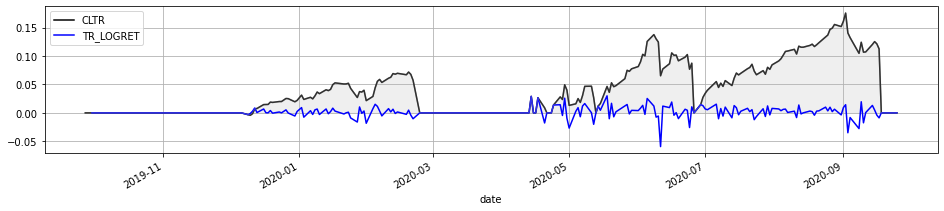

In [18]:
cltr = trendy.iloc[:,0]
tr = trendy.iloc[:,1]

trendy.iloc[:,:2].plot(figsize=(16, 3), color=colors("BkBl"))
cltr.plot(figsize=(16, 3), kind="area", stacked=False, color=colors("SvGy")[0], alpha=0.25, grid=True)

# Total Return

<AxesSubplot:xlabel='date'>

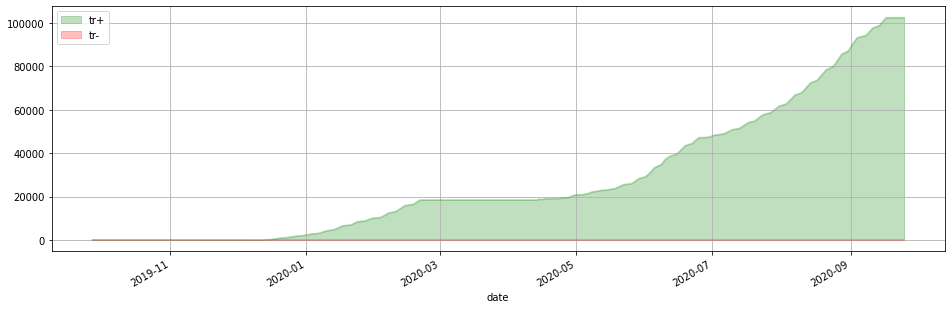

In [19]:
capital = 10000

total_return = cltr.cumsum() * capital
positive_return = total_return[total_return > 0]
negative_return = total_return[total_return <= 0]
trdf = pd.DataFrame({"tr+": positive_return, "tr-": negative_return})
trdf.plot(figsize=(16, 5), color=colors(), kind="area", stacked=False, alpha=0.25, grid=True)

## Long and Short Trends

<AxesSubplot:xlabel='date'>

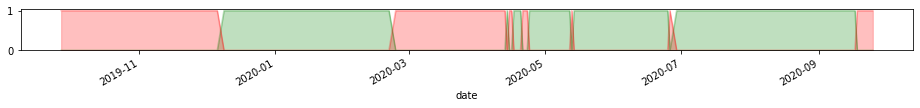

In [20]:
long_trend = (trendy.iloc[:,-2] > 0).astype(int)
short_trend = (1 - long_trend).astype(int)

long_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[0], alpha=0.25)
short_trend.plot(figsize=(16, 0.85), kind="area", stacked=True, color=colors()[1], alpha=0.25)

## Entries & Exits

Total Trades: 12


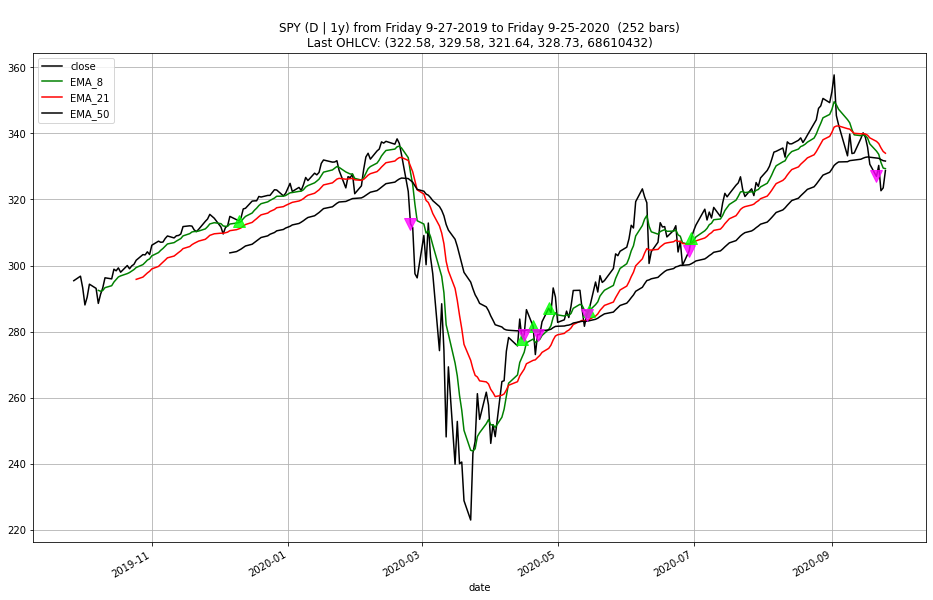

In [21]:
entries = (trendy.iloc[:,-1] > 0).astype(int) * asset.close
entries[entries < 0.0001] = np.NaN
entries.name = "entries"
exits = (trendy.iloc[:,-1] < 0).astype(int) * asset.close
exits[exits < 0.0001] = np.NaN
exits.name = "exits"

first_date = asset.index[0]
last_date = asset.index[-1]
f_date = f"{first_date.day_name()} {first_date.month}-{first_date.day}-{first_date.year}"
l_date = f"{last_date.day_name()} {last_date.month}-{last_date.day}-{last_date.year}"
last_ohlcv = f"Last OHLCV: ({asset.iloc[-1].open}, {asset.iloc[-1].high}, {asset.iloc[-1].low}, {asset.iloc[-1].close}, {int(asset.iloc[-1].volume)})"
ptitle = f"\n{ticker} ({tf} | {duration}) from {f_date} to {l_date}  ({recent} bars)\n{last_ohlcv}"

# chart = asset["close"] #asset[["close", "SMA_10", "SMA_20", "SMA_50", "SMA_200"]]
# chart = asset[["close", "SMA_10", "SMA_20"]]
chart = asset[["close", "EMA_8", "EMA_21", "EMA_50"]]
chart.plot(figsize=(16, 10), color=colors("BkGrRd"), title=ptitle, grid=True)
entries.plot(figsize=(16, 10), color=colors("FcLi")[1], marker="^", markersize=12, alpha=0.8)
exits.plot(figsize=(16, 10), color=colors("FcLi")[0], marker="v", markersize=12, alpha=0.8, grid=True)

total_trades = trendy.iloc[:,-1].abs().sum()
print(f"Total Trades: {total_trades}")

entries_ = entries.dropna()
exits_ = exits.dropna()
all_trades = trendy.iloc[:,-1].copy().dropna()
# all_trades[all_trades != 0]

# AI Analysis